GitHub link https://github.com/peter9405/PracticumDS_project 

# Проект: Обучение с учителем: качество модели.

Введение:

- В данном проекте будет проведен анализ данных покупателей интернет магазина «В один клик».
- Возникшая проблема - снижение активности клиентов.
- Разработка решения будет включать:
    - исследовательский анализ текущих данных
    - корреляционный анализ данных
    - выбор лучшей модели МО для определения факторов наиболее влияющих на снижение покупательской активности
    - анализ и ранжирование факторов влияющих на целевой
    - предложения по решению проблемы
    
- Будут использованы:
    - Модели МО KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC()
    - Передовые методы кодирования и масштабирования данных
    - Метрики и выбор решения на основе данных

### Загрузка данных

In [1]:
!pip install phik -q
! pip install scikit-learn==0.24.1 -q # Это дефолтная версия sklearn в Практикуме и твой код написан под неё, но если вдруг будет другая, то могут возникнуть ошибки.


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import shap

#### Загрузите данные.

In [5]:
market = pd.read_csv('./market_file.csv')
revenue = pd.read_csv('./market_money.csv')
time = pd.read_csv('./market_time.csv')
rev_avg = pd.read_csv('./money.csv', sep=';', decimal=',')

#### Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [6]:
for table in [market,revenue,time,rev_avg]:
    table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Таблицы соотвутствуют описаниям

###  Предобработка данных

In [7]:
for df in [market,revenue,time,rev_avg]:
    print('Проверка на явные дубли:', df.duplicated().sum())

Проверка на явные дубли: 0
Проверка на явные дубли: 0
Проверка на явные дубли: 0
Проверка на явные дубли: 0


Явные дубли в таблицах отсутствуют.

In [8]:
for df in [market,revenue,time,rev_avg]:
    print(df.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
id         0
Период     0
Выручка    0
dtype: int64
id        0
Период    0
минут     0
dtype: int64
id         0
Прибыль    0
dtype: int64


Пропущенных значений не наблюдаем

In [9]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [11]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [13]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [15]:
rev_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [16]:
rev_avg.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


По единице измерения выручки нам не сообщили, тысячи это и рубли ли, но это пока нам не важно, в каком формате предоставили в таком и выдадим

Проверим на неявные дубликаты

In [17]:
for column in market.select_dtypes(include='object').columns:
    print(market[column].value_counts())

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64
Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64
Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64
Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


market[тип сервиса], необходимо поправить стандартт на стандарт 

market.columns привести названия к единому змеиному формату

In [18]:
market.loc[market['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'

In [19]:
market = market.rename(columns={'Покупательская активность':'Покупательская_активность',
                               'Тип сервиса':'Тип_сервиса',
                               'Разрешить сообщать':'Разрешить_сообщать'})

In [20]:
revenue['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [21]:
time['Период'].value_counts()

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

Скоректируем "предыцщий месяц" в таблице time

In [22]:
time.loc[time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

На этапе предобработки данных:
- явные дубликаты в таблицах не обнаружены
- пропущенные значения не обнаружены
- обнаружены несколько опечаток в категориальных данных, исправлены
- переименованы несколько столбцов под общий формат

### Исследовательский анализ данных

In [23]:
def exploratory_analysis(df):
    numerical_columns = df.select_dtypes(include=[int,'float64']).columns
    categorical_columns = df.select_dtypes(include=[object]).columns
    for i in numerical_columns[1:]:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        bins= ax1.hist(x=df[i])
        ax1.vlines(x=df[i].mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
        ax1.vlines(x=df[i].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
        ax1.set_title(f'Гистограмма распределения: {i}')
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax1.legend(loc='upper right', framealpha=0.3)

        ax2.boxplot(df[i], vert=False)
        ax2.set_title(f'Boxplot: {i}')
        ax2.set_xlabel('Значения')
        ax2.set_yticks([])
        y = np.ones_like(df[i])  
        ax2.scatter(df[i], y, color='blue', alpha=0.5, label='Значения')
        ax2.legend(loc='upper right')
        
    plt.figure(figsize=(2, 2))
    plt.show()
    
    for i in categorical_columns:
        my_circle = plt.Circle( (0,0), 0.7, color='white')
        y = df[i].value_counts()
        x = df[i].unique()
        plt.pie(y, labels=x,autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(y))})',wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
        p = plt.gcf()
        p.gca().add_artist(my_circle)
        plt.title(f'Распределение признака "{i}"')
        plt.show()

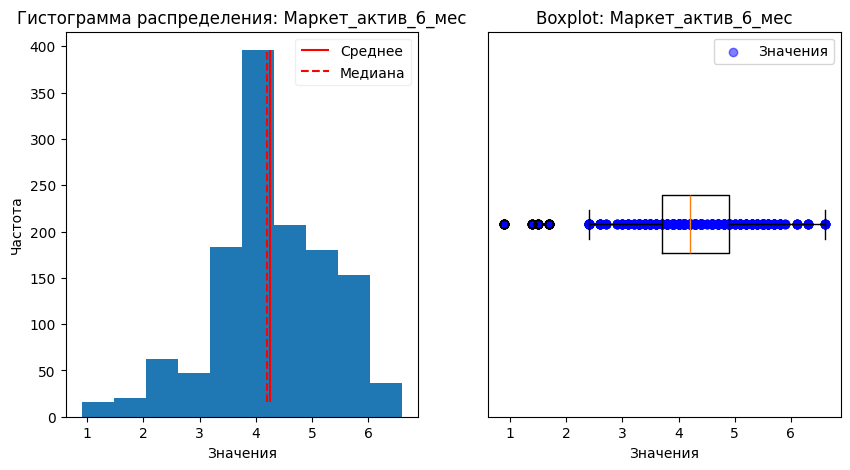

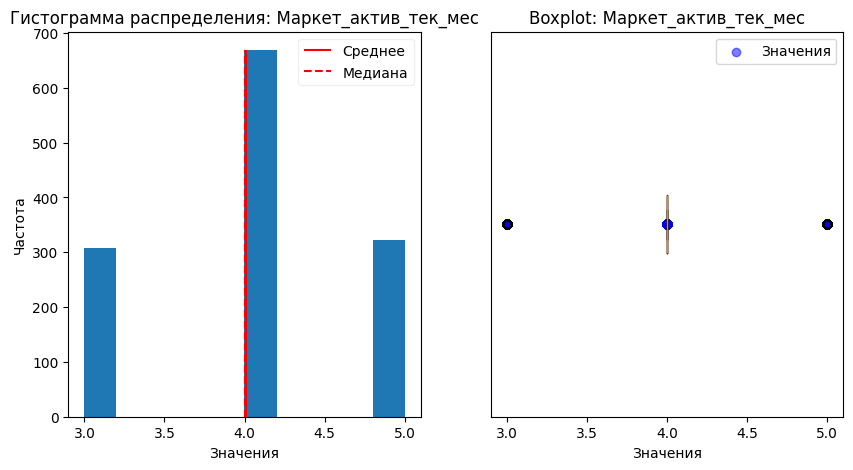

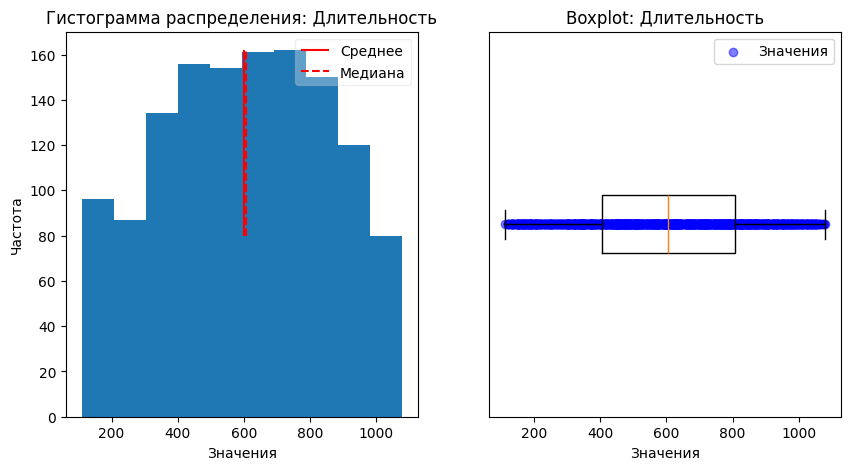

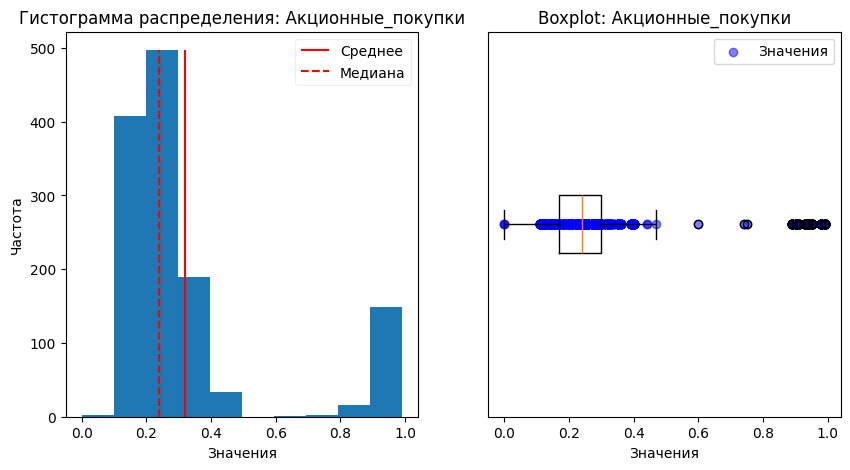

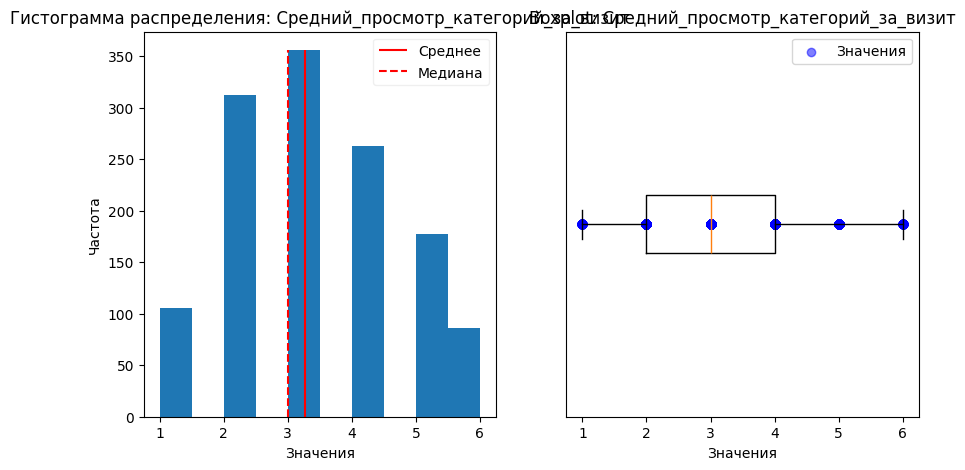

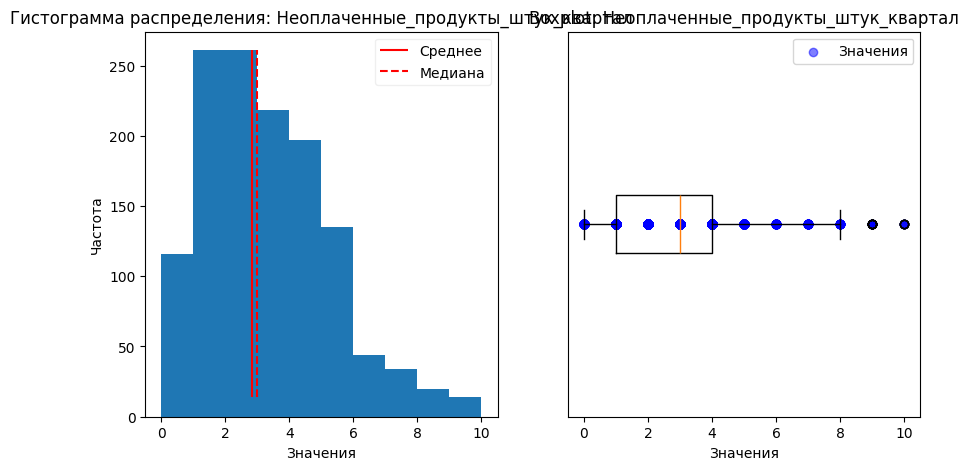

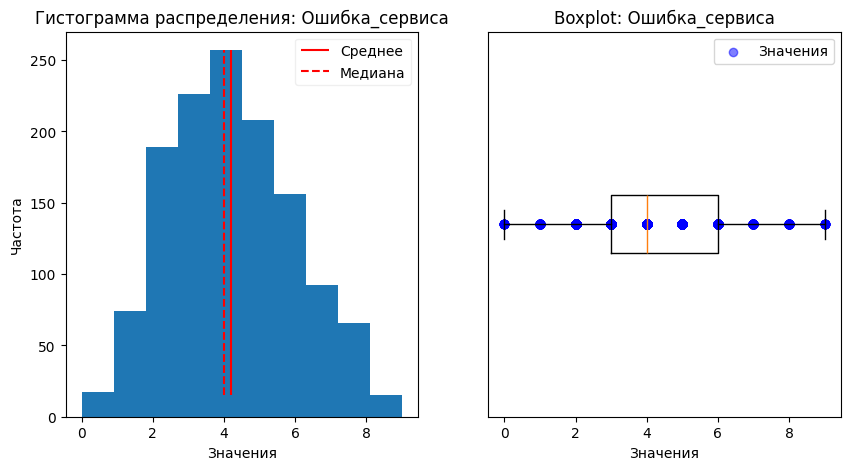

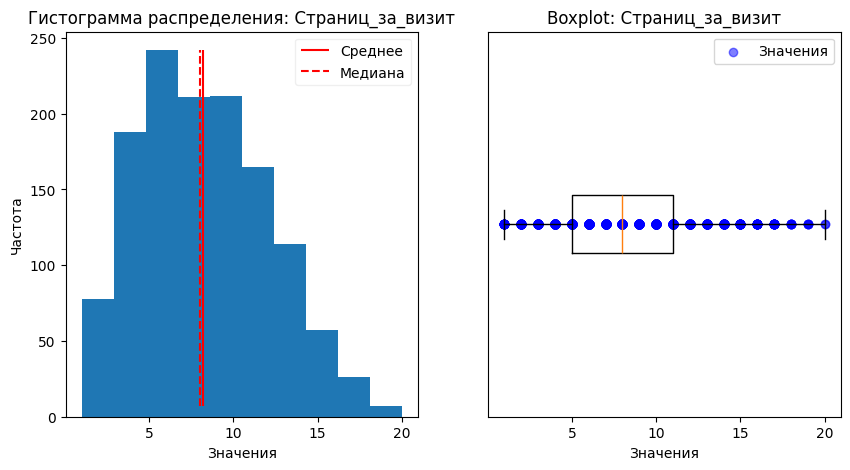

<Figure size 200x200 with 0 Axes>

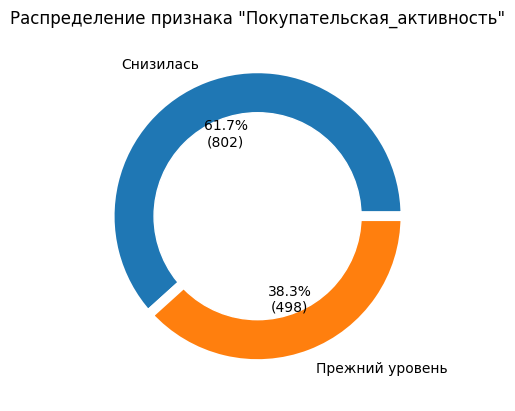

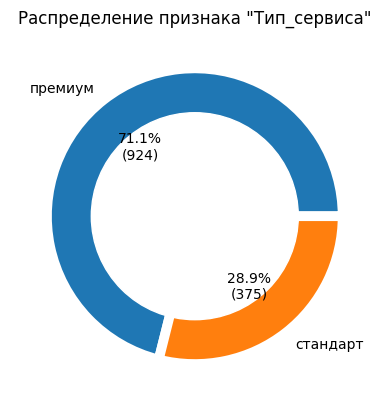

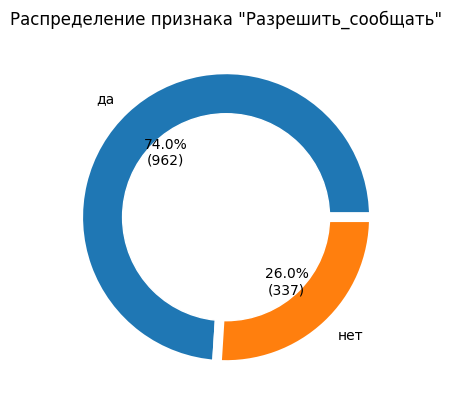

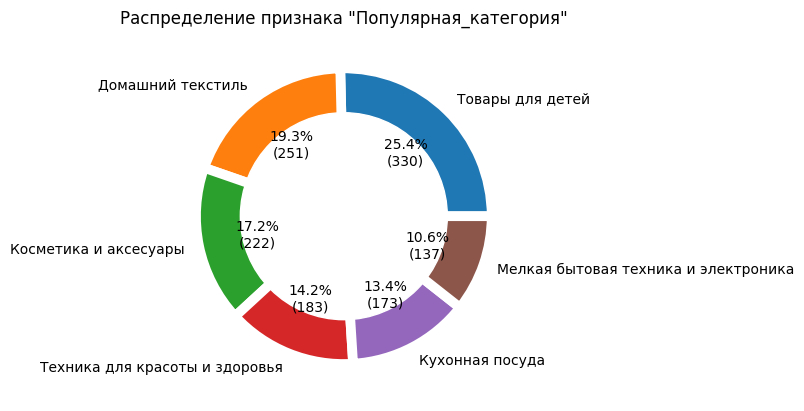

In [24]:
exploratory_analysis(market)

In [25]:
market.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Итак, количественные признаки:
- Маркет_актив_6_мес средняя почти равна медиане, 4,2, распределение близко к нормальному, но есть выбросы с меньшей стороны
- Маркет_актив_тек_мес кандидат на перевод в категориальный признак.3 значения: 3,4,5
- Длительность среднее почти равно медиане, выбросов нет
- Акционные_покупки много выбросов перетягивающих среднее к 0,31 при медиане равной 0,24. наблюдается 2 пика в распределении, 0,24 и в области выбросов в 0.9
- Средний_просмотр_категорий_за_визит -Среднее почти равно медиане, 3,27 и 3 соответственно, выбросов нет.
- Неоплаченные_продукты_штук_квартал, распределение смещено влево, среднее 2,84, медиана 3, есть выбросы справа.
- Ошибка_сервиса распределение похоже на нормальное, медиана и среднее почти равны 4
- Страниц_за_визит среднее почти равно медиане, 8 и 8,17, выбросов нет

Категориальные признаки:
- Покупательская активность. 62% - снизилась, 38 - прежний уровень
- Тип сервиса. 71% премиум, 29% стандарт
- Разрешить сообщать. 74% да, 26% - нет
- Популярная_категория. Товары для детей наиболее популярная категория, 25%,  далее по убыванию - домашний текстиль,косметика и аксесуары, техника для красоты и здоровья, кухонная посуда, мелк быт техника.

In [26]:
market.query('Маркет_актив_6_мес < 2.3 ')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
30,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,Снизилась,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,Снизилась,премиум,да,1.4,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,Снизилась,стандарт,да,1.7,4,756,0.33,Товары для детей,2,3,7,4
70,215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
81,215429,Снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
108,215456,Снизилась,стандарт,да,1.7,4,449,0.23,Косметика и аксесуары,3,4,4,5


In [27]:
market.query('Акционные_покупки > 0.6')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
14,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4
16,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,216602,Прежний уровень,стандарт,нет,3.4,5,170,0.95,Техника для красоты и здоровья,4,1,3,10
1256,216604,Прежний уровень,стандарт,да,4.9,5,350,0.99,Домашний текстиль,3,4,5,5
1257,216605,Прежний уровень,стандарт,да,3.2,4,568,0.94,Мелкая бытовая техника и электроника,5,1,7,11
1292,216640,Прежний уровень,стандарт,нет,5.7,4,416,0.95,Кухонная посуда,2,3,5,13


In [28]:
market.query('Неоплаченные_продукты_штук_квартал > 8')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
72,215420,Снизилась,стандарт,да,3.5,5,449,0.35,Домашний текстиль,1,9,2,2
73,215421,Снизилась,премиум,нет,4.0,5,523,0.94,Техника для красоты и здоровья,1,10,7,5
117,215465,Снизилась,стандарт,да,3.5,5,449,0.28,Домашний текстиль,1,9,2,2
118,215466,Снизилась,премиум,нет,2.4,5,523,0.30,Техника для красоты и здоровья,1,10,1,4
176,215524,Снизилась,стандарт,да,3.0,3,474,0.23,Техника для красоты и здоровья,1,10,4,2
186,215534,Снизилась,премиум,нет,4.0,4,419,0.93,Товары для детей,1,9,3,3
204,215552,Снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
216,215564,Снизилась,стандарт,нет,3.9,3,618,0.24,Техника для красоты и здоровья,2,10,3,5
246,215594,Снизилась,стандарт,да,4.2,4,627,0.90,Товары для детей,6,9,5,8
251,215599,Снизилась,стандарт,да,3.4,4,716,0.28,Домашний текстиль,2,9,4,6


- Касатаельно выбросов Маркет_актив_6_мес, вполне вероятно, что этот реальные данные и, думаю их нужно оставить. 
- Аналогично можно сказать и по высокой доле акционных покупок, видимо есть доля клиентов которые покупают подавляющее товаров только по акции, возможно их можно будет выделить в отдельную группу.
- Неоплаченные_продукты_штук_квартал более 8, наблюдений немного, нет оснований полагать что данные не достоверны и следовательно их нужно оставить. При составлении моделей МО и выбора метрик будем учитывать наличие выбросов в данных

Проверим, что одному id соотвествует одна запись в таблице 

In [29]:
market.id.nunique() - len(market)

0

In [30]:
market['Маркет_актив_тек_мес'].value_counts()

Маркет_актив_тек_мес
4    669
5    323
3    308
Name: count, dtype: int64

Попробуем перевести в категориальный признак , мало, средне, много (Это понадобится нам для испольваония Ordinal кодировщика ниже)

In [31]:
market['марк_акт_тек_мес_cat'] = market['Маркет_актив_тек_мес'].apply(lambda x: 'много' if x==5 else
                                                                     ('средне' if x==4 else 'мало'))

In [32]:
market.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,марк_акт_тек_мес_cat
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,много
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,средне
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,мало
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,много
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,мало


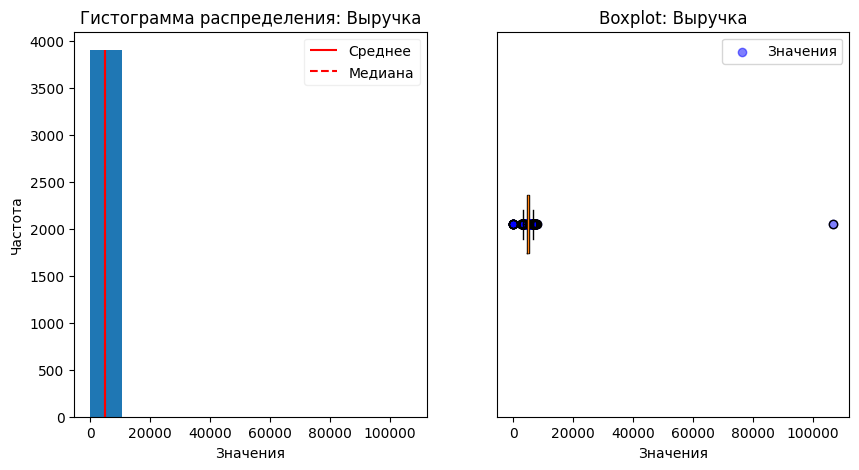

<Figure size 200x200 with 0 Axes>

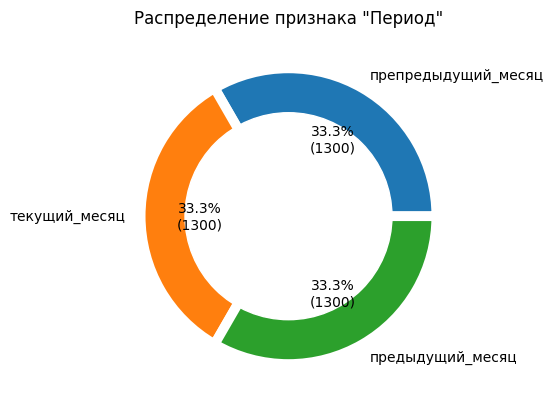

In [33]:
exploratory_analysis(revenue)

In [34]:
revenue.query('Выручка > 20000')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [35]:
revenue.query('id == 215380')

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


посмотрим этот id в таблице market

In [36]:
market.query('id ==215380')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,марк_акт_тек_мес_cat
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,средне


Похоже на ошибку, выручка должна была снизиться в текущем месяце, Покупательская_активность == снизилась.
Заменим на среднее по 2м предыдущим месяцам.

In [37]:
revenue.iloc[98,2] = revenue.query('id == 215380 & Период !="текущий_месяц"')['Выручка'].mean()

Снова построим графики

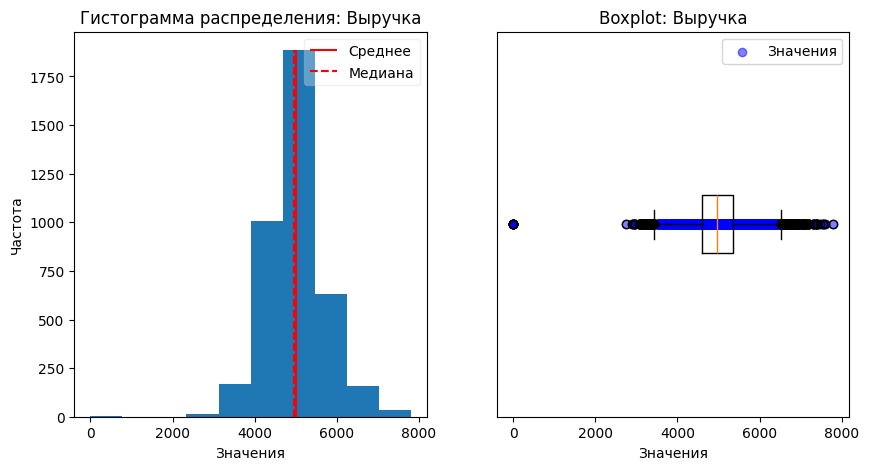

<Figure size 200x200 with 0 Axes>

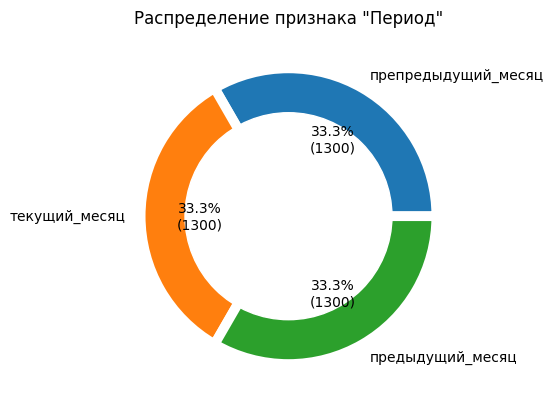

In [38]:
exploratory_analysis(revenue)

Наблюдаем очень маленькое значение помимо выбросов

In [39]:
revenue.query('Выручка < 2000')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [40]:
ids_low_revenue = revenue.query('Выручка < 2000')['id'].to_list()

In [41]:
revenue.query('id in @ids_low_revenue')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [42]:
market.query('id in @ids_low_revenue')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,марк_акт_тек_мес_cat
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,много
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,много
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,много


- Наблюдаем нехватку данных, покупательская автивность по покупателям выше снизилась, но данные по тратам за пред. месяцы равна 0.
- Согласно заданию, отберем только данные тех покупателей, которые что то покупали в течение и не менее 3х месяцев

In [43]:
market = market.query('id not in @ids_low_revenue').reset_index(drop=True)

In [44]:
market.shape

(1297, 14)

In [45]:
revenue = revenue.query('id not in @ids_low_revenue').reset_index(drop=True)

In [46]:
revenue.shape

(3891, 3)

In [47]:
revenue.groupby('id')['Период'].count().reset_index().query('Период < 3')

,id,Период


Проверили, оставили только id у которых были траты в течение трех крайних месяцев.

In [48]:
time = time.query('id not in @ids_low_revenue').reset_index(drop=True)

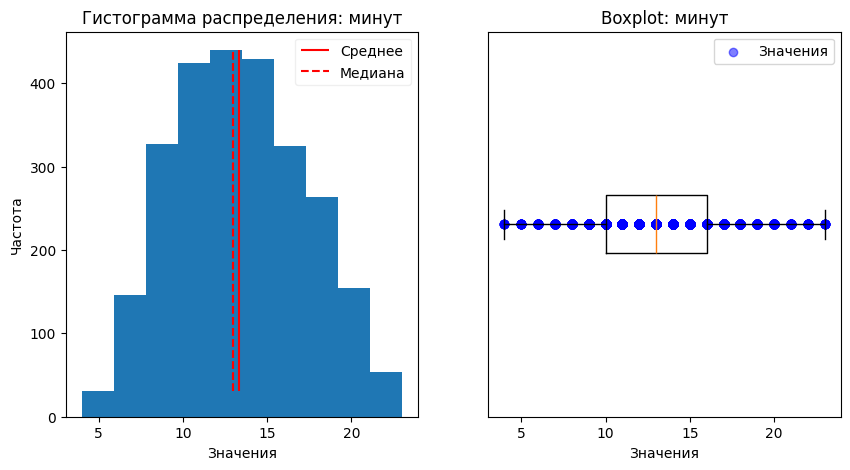

<Figure size 200x200 with 0 Axes>

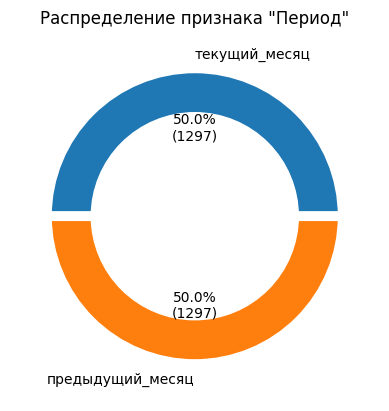

In [49]:
exploratory_analysis(time)

In [50]:
time.describe()

,id,минут
count,2594.000000,2594.000000
mean,215998.986893,13.340401
std,374.506318,4.081999
min,215349.000000,4.000000
25%,215675.000000,10.000000
50%,215999.000000,13.000000
75%,216323.000000,16.000000
max,216647.000000,23.000000


- Время проведенное на сайте распределено нормально, медиана почти равна среднему 13 минут, выбросов нет
- А вот данные есть только по текущему и предыдущему месяцу

In [51]:
rev_avg = rev_avg.query('id not in @ids_low_revenue')
rev_avg.shape

(1297, 2)

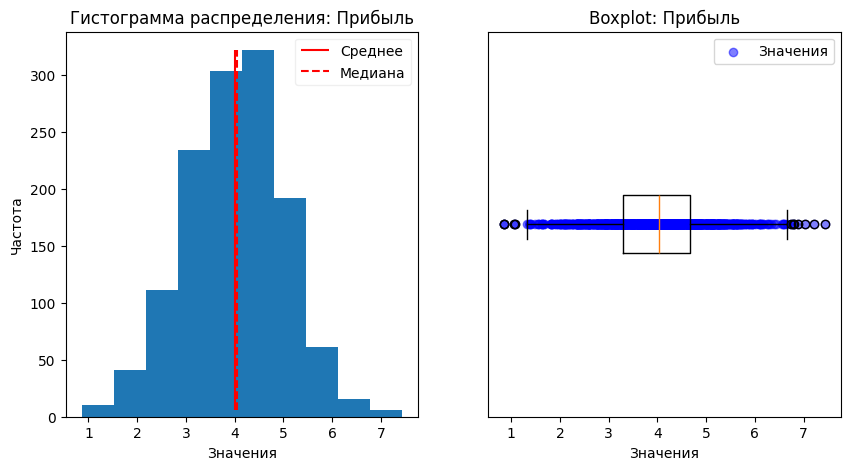

<Figure size 200x200 with 0 Axes>

In [52]:
exploratory_analysis(rev_avg)

In [53]:
rev_avg.describe()

,id,Прибыль
count,1297.000000,1297.000000
mean,215998.986893,3.997610
std,374.578554,1.010813
min,215349.000000,0.860000
25%,215675.000000,3.300000
50%,215999.000000,4.040000
75%,216323.000000,4.670000
max,216647.000000,7.430000


- среднемесячная прибыль распределение похоже на нормальное, медиана почти равна среднему, 4. есть выбросы
- аналогично первой таблице market, мы оставляем выбросы и учтем это при составлении моделей МО и выбора метрик к ним

### Объединение таблиц

#### Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [54]:
revenue_pivot = revenue.pivot(index='id',columns='Период',values='Выручка')
revenue_pivot.columns = ['выручка_пред_месяц','выручка_препред_месяц','выручка_тек_месяц']
revenue_pivot.head()

,выручка_пред_месяц,выручка_препред_месяц,выручка_тек_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [55]:
time_pivot = time.pivot(index='id',columns='Период', values='минут')
time_pivot.columns = ['мин_на_сайте_пред_месяц','мин_на_сайте_тек_месяц']
time_pivot.head()

,мин_на_сайте_пред_месяц,мин_на_сайте_тек_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [56]:
market.set_index('id', inplace=True)
market = market.join([revenue_pivot, time_pivot])

In [57]:
market.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,марк_акт_тек_мес_cat,выручка_пред_месяц,выручка_препред_месяц,выручка_тек_месяц,мин_на_сайте_пред_месяц,мин_на_сайте_тек_месяц
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,средне,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,мало,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,много,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,мало,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,средне,4738.5,5124.0,5388.5,10,10


In [58]:
market.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1297 non-null   object 
 1   Тип_сервиса                          1297 non-null   object 
 2   Разрешить_сообщать                   1297 non-null   object 
 3   Маркет_актив_6_мес                   1297 non-null   float64
 4   Маркет_актив_тек_мес                 1297 non-null   int64  
 5   Длительность                         1297 non-null   int64  
 6   Акционные_покупки                    1297 non-null   float64
 7   Популярная_категория                 1297 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  Ошибка_сервиса                       1297 non-null   int64  
 11  Страниц_за_визит            

Объединение выполнено успешно

### Корреляционный анализ

In [59]:
numerical_columns = market.select_dtypes(include=[int,'float64']).columns

In [60]:
corr_matrix = market.phik_matrix(interval_cols=numerical_columns)

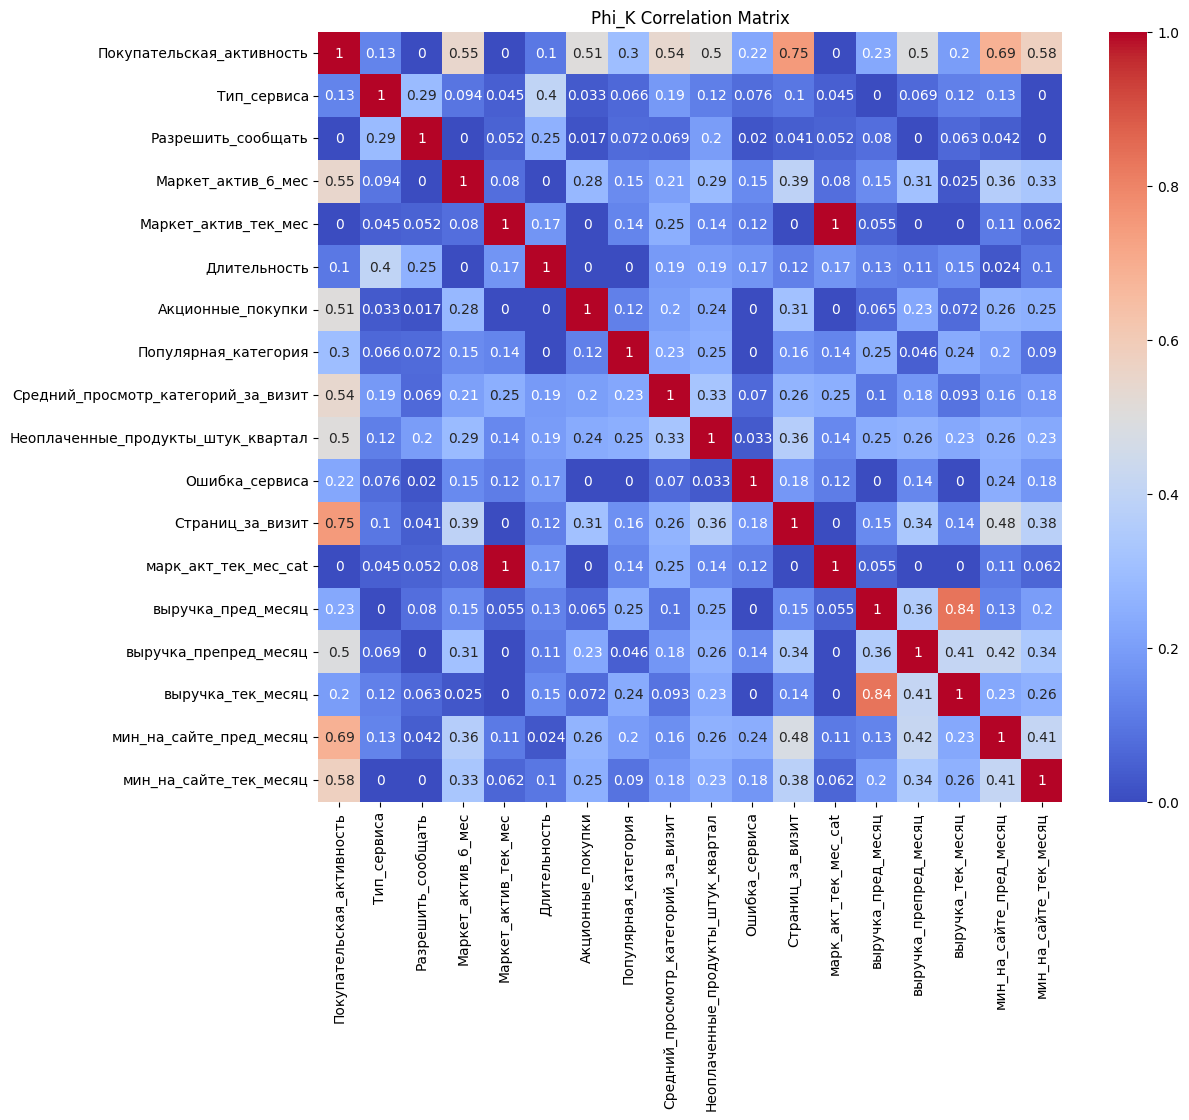

In [61]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Итак, корреляция
- Целевой признак Покупательская активность имеет заметную положительную связь, согласно шкале Чеддока, с Маркет_актив_6_мес, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, выручка_препред_месяц мин_на_сайте_тек_месяц, коефициенты корреляции phik от 0,5 до 0,58
- Целевой признак Покупательская активность имеет высокую положительную связь с признаками Страниц_за_визит, мин_на_сайте_пред_месяц, 0.75 и 0.69 коефициенты phik соответвственно.
- Целевой признак Покупательская активность имеет слабую связь с признаками Тип_сервиса, Популярная_категория, Ошибка_сервиса, выручка_пред_месяц, выручка_тек_месяц.

Мультиколлинеарность
- Корреляция между входными признаками менее 0,9, мультиколлинеарность отсутствует. 

Итак, несмотря на то, что Фик показывает и линейные и не линейные связи, возьмем входные признаки с коефициентами больше 0,1.

In [62]:
df_model = market[['Покупательская_активность',
                   'Маркет_актив_6_мес', 
                   'Акционные_покупки',
                  'Средний_просмотр_категорий_за_визит',
                  'Неоплаченные_продукты_штук_квартал',
                  'выручка_препред_месяц',
                  'мин_на_сайте_тек_месяц',
                  'Страниц_за_визит',
                  'мин_на_сайте_пред_месяц',
                   'Ошибка_сервиса',
                  'Популярная_категория',
                  'Тип_сервиса',
                  'марк_акт_тек_мес_cat',
                  'выручка_пред_месяц',
                  'выручка_тек_месяц']]
df_model.head()

,Покупательская_активность,Маркет_актив_6_мес,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,выручка_препред_месяц,мин_на_сайте_тек_месяц,Страниц_за_визит,мин_на_сайте_пред_месяц,Ошибка_сервиса,Популярная_категория,Тип_сервиса,марк_акт_тек_мес_cat,выручка_пред_месяц,выручка_тек_месяц
id,,,,,,,,,,,,,,,
215349,Снизилась,4.4,0.75,4,4,4472.0,10,5,12,2,Товары для детей,премиум,средне,5216.0,4971.6
215350,Снизилась,4.9,0.14,5,2,4826.0,13,5,8,1,Домашний текстиль,стандарт,мало,5457.5,5058.4
215351,Снизилась,3.2,0.99,5,0,4793.0,13,4,11,6,Товары для детей,стандарт,много,6158.0,6610.4
215352,Снизилась,5.1,0.94,3,2,4594.0,11,2,8,3,Товары для детей,стандарт,мало,5807.5,5872.5
215353,Снизилась,3.3,0.26,4,1,5124.0,10,4,10,1,Домашний текстиль,стандарт,средне,4738.5,5388.5


In [63]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1297 non-null   object 
 1   Маркет_актив_6_мес                   1297 non-null   float64
 2   Акционные_покупки                    1297 non-null   float64
 3   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 4   Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 5   выручка_препред_месяц                1297 non-null   float64
 6   мин_на_сайте_тек_месяц               1297 non-null   int64  
 7   Страниц_за_визит                     1297 non-null   int64  
 8   мин_на_сайте_пред_месяц              1297 non-null   int64  
 9   Ошибка_сервиса                       1297 non-null   int64  
 10  Популярная_категория                 1297 non-null   object 
 11  Тип_сервиса                 

DataFrame для создания моделей МО подготовлен, значимые признаки по коеф. корреляции Фик добавлены

### Использование пайплайнов
Примените все изученные модели. Для этого используйте пайплайны.

Взглянем еще раз на данные для обучения, особенно убедимся что в категориальных признаках нет лишних категорий.

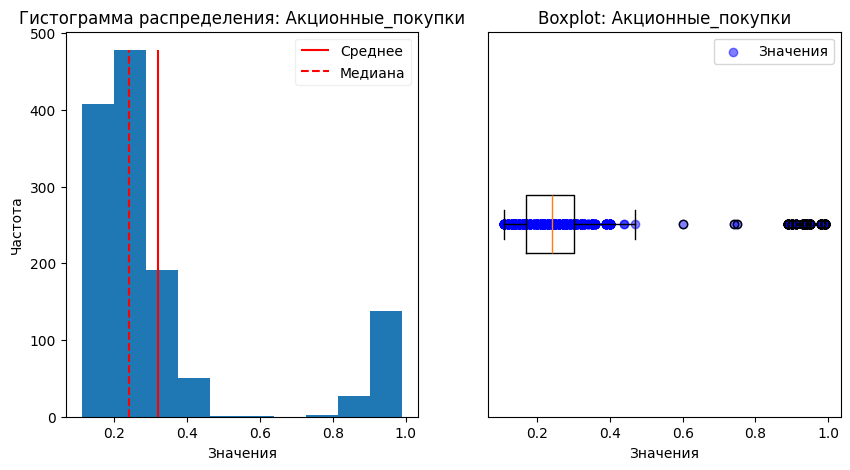

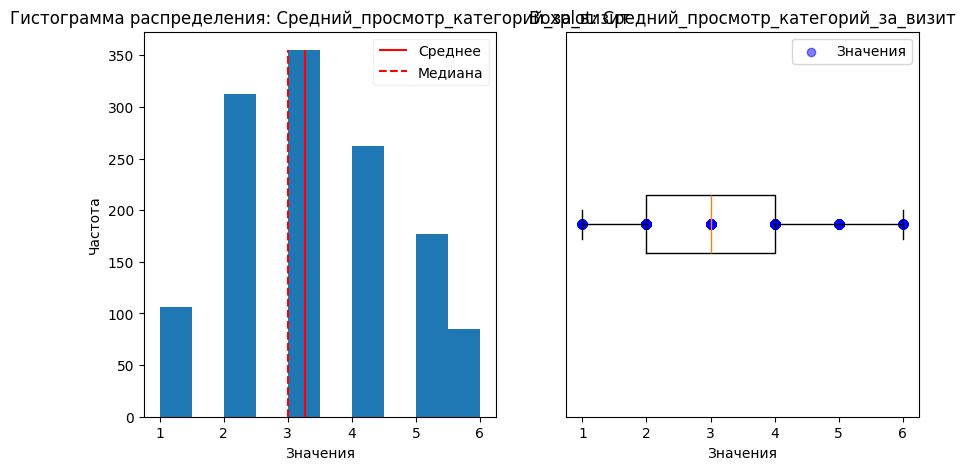

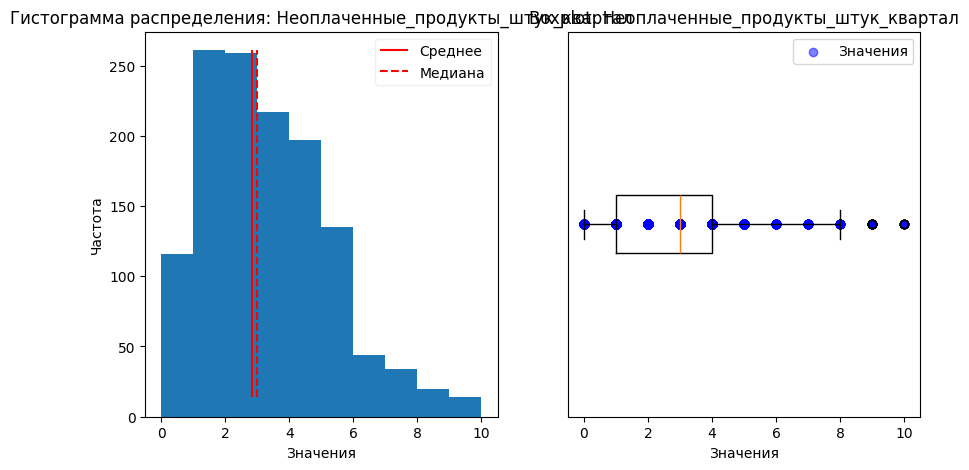

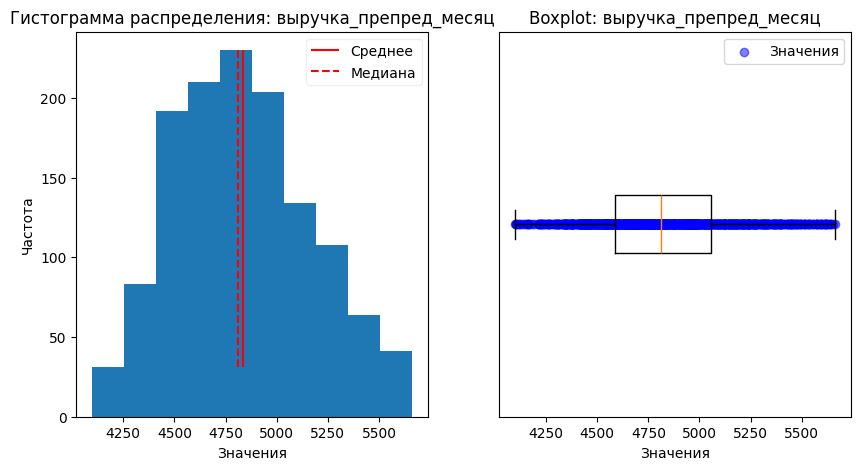

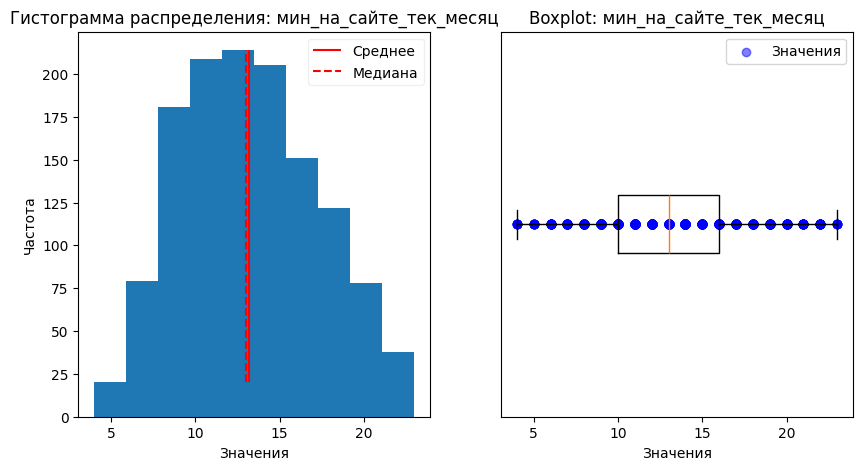

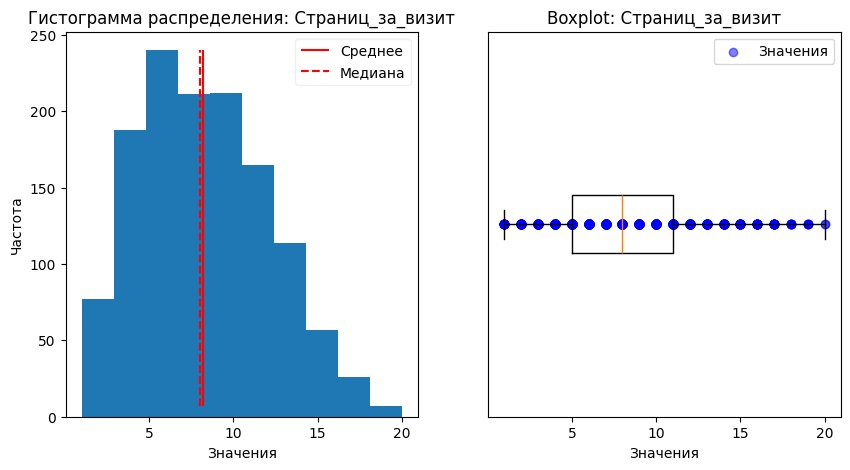

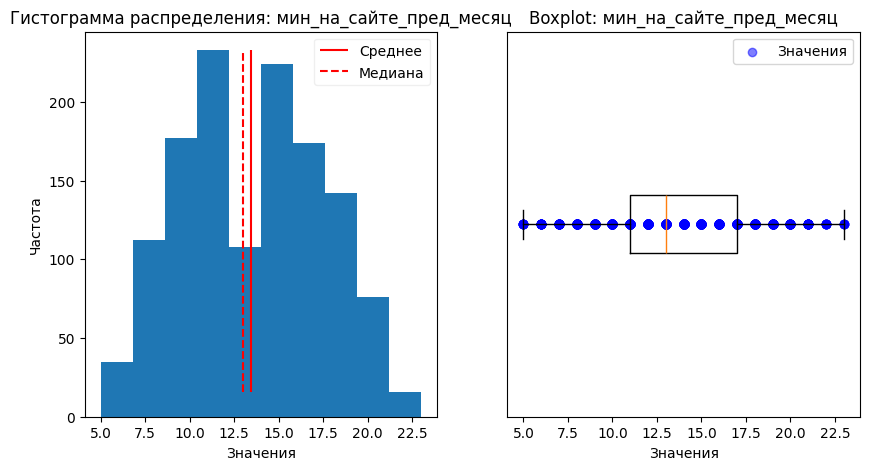

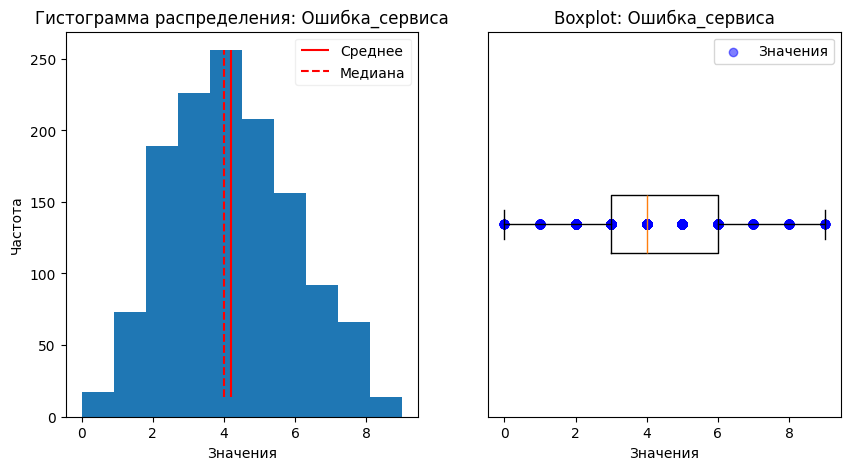

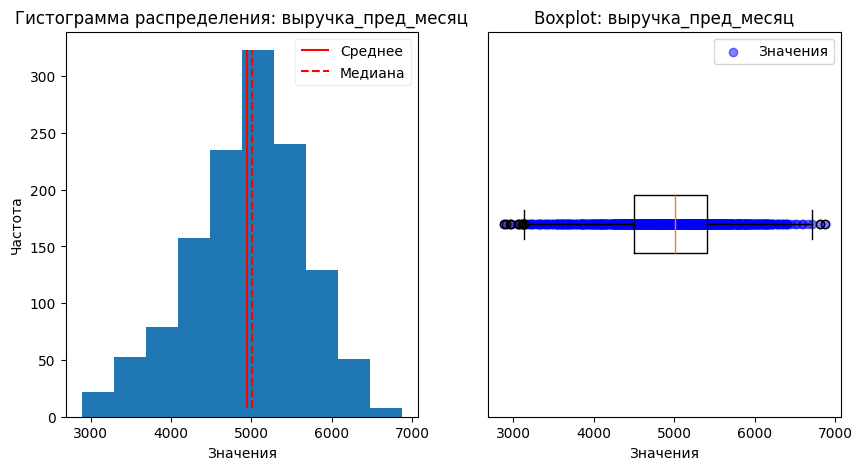

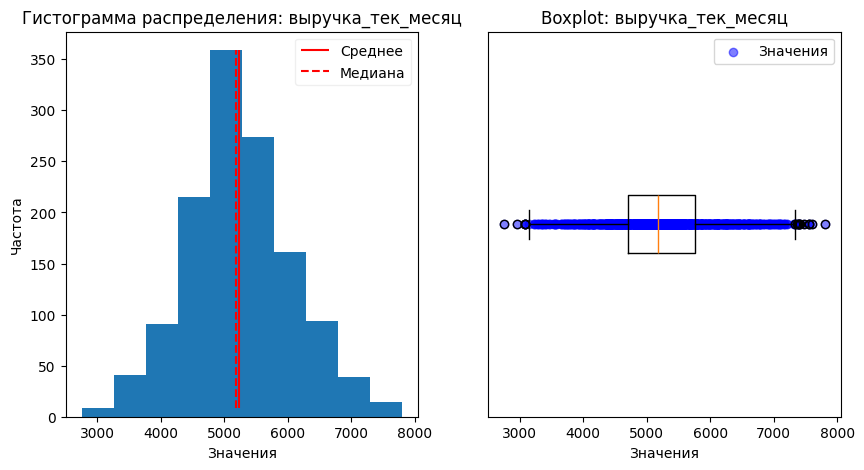

<Figure size 200x200 with 0 Axes>

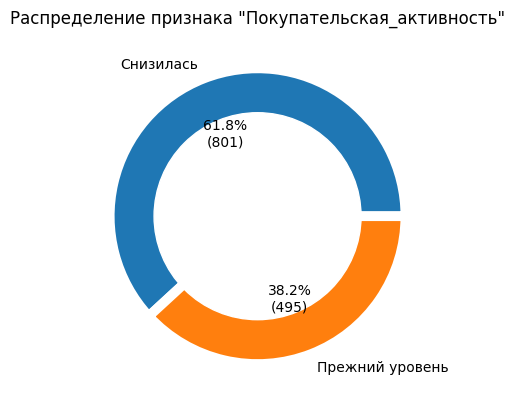

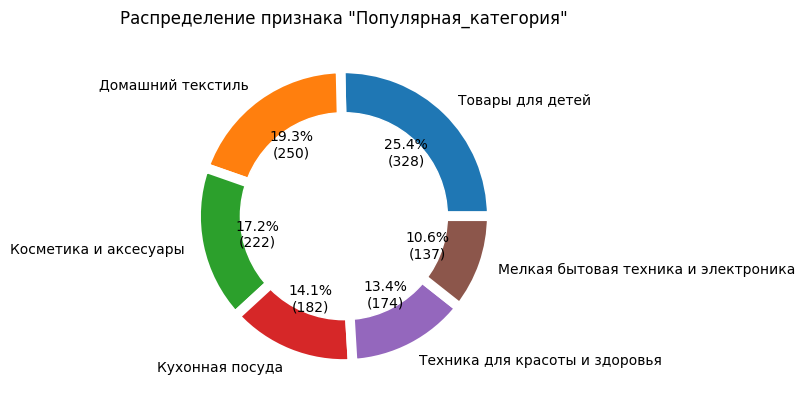

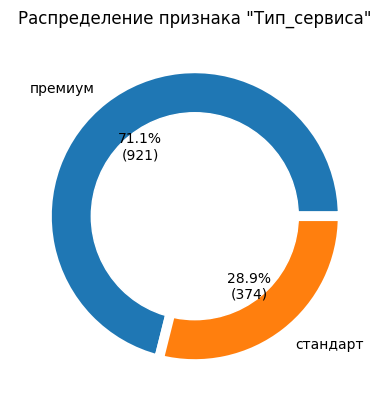

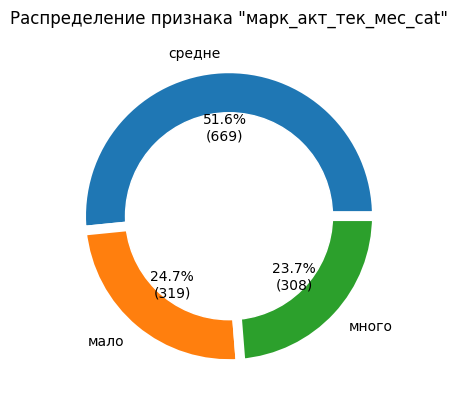

In [64]:
exploratory_analysis(df_model)

не забываем про дисбаланс целевого признака, используем stratify при разделение df

In [65]:
X = df_model.drop(columns=['Покупательская_активность'])
y = df_model['Покупательская_активность']

In [66]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y)

Выведем размеры тренировочной и валидационной выборки, она же тестовая в нашем случае. Это поможет определить какое ядро предпочтительней использовать в моделе опорных векторов

In [68]:
X_train.shape, X_test.shape

((972, 14), (325, 14))

Сделаем шаги по предобработке данных, и образуем из них финальный пайплайн

In [69]:
ohe_cols = ['Тип_сервиса', 'Популярная_категория']
ord_cols = ['марк_акт_тек_мес_cat']
num_cols = X.select_dtypes(include=[int,'float64']).columns.to_list()

In [71]:
ohe_pipe = Pipeline([('ohe',OneHotEncoder(drop='first', sparse_output=False))])

In [72]:
ord_pipe = Pipeline([('ord', OrdinalEncoder(categories=[['мало','средне','много']]))])

In [111]:
data_preprocessor = ColumnTransformer(
[('ohe', ohe_pipe, ohe_cols),
('ord', ord_pipe, ord_cols),
('num', StandardScaler(), num_cols)],
remainder='passthrough')

In [74]:
pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', LogisticRegression(random_state=RANDOM_STATE))
])

Теперь составим словарь список словарей с параметрами, которые передадим RandomizedSearch или GridSearch для перебора. Пропишем также гиперпараметры для каждой из 4х моделей, чтобы их тоже перепробовали, равно как и разные скейлеры для количественных столбцов

In [112]:
param_grid = [
    {
     'models': [LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear',
        penalty='l1'
    )],
    'models__C': range(1,7),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__max_depth': range(2,7),
    'models__max_features': range(2,7),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']    
    },
    
    {
    'models': [KNeighborsClassifier()],
    'models__n_neighbors': range(2,7),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']    
    },
    
    {
    'models': [SVC(kernel='poly',probability=True,random_state=RANDOM_STATE)],
    'models__degree': range(2,7),
    'models__C': range(1,5),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']    
    }
]

запустим сперва для эксперимента randomized search, а затем gridsearch, в котором уже переберем все комбинации

Предлагаю использовать метрику ROC AUC SCORE для оценки работы моделей.

ROC AUC измеряет способность модели различать положительный и отрицательный классы, в нашем случае, снилазь ли покупательская активность или осталась преженей. Чем выше значение ROC AUC, тем лучше модель справляется с этой задачей.

ROC AUC оценивает способность модели различать классы на основе вероятностных предсказаний. Это особенно важно в ситуациях, когда классы несбалансированы, и простая метрика, такая как точность (accuracy), может быть вводящей в заблуждение.

In [76]:
randomized_search = RandomizedSearchCV(
pipe_final,
param_grid,
cv=5,
scoring='roc_auc',
random_state=RANDOM_STATE,
n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Тип_сервиса',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['мало',
                                                                                                                            'средне',
                                                                                                                            'много']]))]),
                                                                               ['марк_акт_тек_мес_...
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__degree': range(2, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [77]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['мало',
                                                                                               'средне',
                                                             

Итак, randomized search - лучшая модель SVC(C=1, degree=4, kernel='poly') c MinMaxScaler(), лучший показатель метрики 0,89

In [78]:
grid_search = GridSearchCV(
pipe_final,
param_grid,
cv=5,
scoring='roc_auc',
n_jobs=-1)

grid_search.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['Тип_сервиса',
                                                                          'Популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['мало',
                                                                                                                      'средне',
                                                                                                                      'много']]))]),
                                                                         ['марк_акт_тек_мес_cat'])...
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(2, 7),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(kernel='poly', probability=True,
                                         random_state=42)],
                          'models__C': range(1, 5),
                          'models__degree': range(2, 7),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [79]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['мало',
                                                                                               'средне',
                                                             

In [80]:
result = pd.DataFrame(grid_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
111,1,"SVC(kernel='poly', probability=True, random_st...",0.903426,"{'models': SVC(kernel='poly', probability=True..."
126,2,"SVC(kernel='poly', probability=True, random_st...",0.902259,"{'models': SVC(kernel='poly', probability=True..."
105,3,"SVC(kernel='poly', probability=True, random_st...",0.902224,"{'models': SVC(kernel='poly', probability=True..."
141,4,"SVC(kernel='poly', probability=True, random_st...",0.901434,"{'models': SVC(kernel='poly', probability=True..."
120,5,"SVC(kernel='poly', probability=True, random_st...",0.900814,"{'models': SVC(kernel='poly', probability=True..."
...,...,...,...,...
29,157,DecisionTreeClassifier(random_state=42),0.732323,{'models': DecisionTreeClassifier(random_state...
27,157,DecisionTreeClassifier(random_state=42),0.732323,{'models': DecisionTreeClassifier(random_state...
14,160,DecisionTreeClassifier(random_state=42),0.679350,{'models': DecisionTreeClassifier(random_state...
13,160,DecisionTreeClassifier(random_state=42),0.679350,{'models': DecisionTreeClassifier(random_state...


А вот при переборе всех параметров по моделям и скейлеров с ними, лучшая модель SVC(C=1, degree=5, kernel='poly', probability=True, random_state=42). 

Модель сможет отличить случайный положительный пример от случайного отрицательного с точностью 90%

Теперь посмотрим, как модель покажет себя на тестовой выборке, убедимся что мы не переобучили модель.

In [81]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Показатель roc_auc_score на тестовой выбоке составляет {round(roc_auc,2)}')

Показатель roc_auc_score на тестовой выбоке составляет 0.91


Получается, что на тестовой выборке в среднем модель сможет отличить случайный положительный пример от случайного отрицательного с точностью 91%

### Анализ важности признаков

Вызовем лучшую модель, а также предобработаем X_train вызвав preprocessor из лучшей модели, чтобы передать в shap

In [82]:
best_model = grid_search.best_estimator_

In [83]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)

In [84]:
X_train_transformed = pd.DataFrame(X_train_transformed)

In [86]:
ohe_feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names_out().tolist()

In [87]:
all_feature_names = ohe_feature_names + ord_cols + num_cols

In [88]:
X_train_transformed.columns = all_feature_names

In [90]:
X_train_transformed.head()

,Тип_сервиса_стандарт,Популярная_категория_Косметика и аксесуары,Популярная_категория_Кухонная посуда,Популярная_категория_Мелкая бытовая техника и электроника,Популярная_категория_Техника для красоты и здоровья,Популярная_категория_Товары для детей,марк_акт_тек_мес_cat,Маркет_актив_6_мес,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,выручка_препред_месяц,мин_на_сайте_тек_месяц,Страниц_за_визит,мин_на_сайте_пред_месяц,Ошибка_сервиса,выручка_пред_месяц,выручка_тек_месяц
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.201728,-0.678514,-0.932470,0.589656,-1.491598,-1.720111,1.959103,1.626929,1.425030,0.294565,0.924482
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.815490,-0.356937,0.548512,1.095968,-0.745914,-0.048641,-1.329317,-0.641902,-1.140974,2.048137,-1.736994
2,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.043015,-0.598120,1.289002,-0.929281,-0.659415,-0.764985,0.694326,-0.137717,-0.627773,-1.213693,-1.726585
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.536342,-0.557923,0.548512,0.083344,0.960211,-0.764985,0.188415,-0.137717,-0.114573,0.241081,-0.011611
4,1.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.439783,0.326416,-0.191979,2.108592,0.050476,-1.003767,-0.570451,-0.137717,-0.114573,1.269406,2.179306


In [91]:
# Код ревьюера.
# Уменьшаем размер входных данных. Ещё есть shap.kmeans().
X_train_sample = shap.sample(X_train_transformed, 50)

In [92]:
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict_proba, X_train_sample)
shap_values = explainer(X_train_sample)

#shap.plots.beeswarm(shap_values)

  0%|          | 0/50 [00:00<?, ?it/s]

In [93]:
shap_values_class_1 = shap_values[..., 1]

In [94]:
shap_explanation = shap.Explanation(shap_values_class_1, feature_names=X_train_sample.columns)

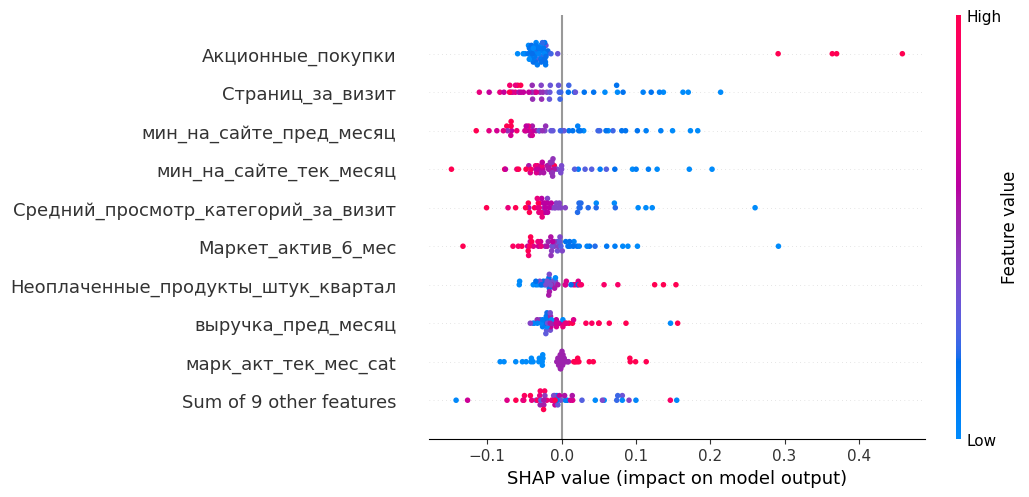

In [95]:
shap.plots.beeswarm(shap_explanation)

Итак, напоминаю, что в нашей модели отрицательный класс присваивается значению пок. активности на прежнем уровне, а положительный - снижение покуп активности.

- на оси Y расположены признаки, сверху вниз в порядке убывания средних SHAP‑значений
- на оси X значения Шепли
- среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев, среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, время проведенное на сайте в текущем и предыдущем месяце, средний просмотр категорий за визит, маркетинговая активность являются самымы значимыми признаками в порядке убывания в модели предсказывания останестя ли Покупательская активность на прежнем уровне или снизится

- чем меньше доля покупок по акции, тем больше шанксов, что траты клиента останутся на прежнем уровне
- чем больше страниц за визит посещено, тем больше шанксов, что траты клиента останутся на прежнем уровне
- чем больше время проведенное на сайте в текущем и предыдущем месяце, тем больше шанксов, что траты клиента останутся на прежнем уровне

- и так далее подробно на визуализации значимости признаков модели выше

### Сегментация покупателей

Итак:

- Так как, привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов.

Рассчитаем вероятности отнесения к классам нашей лучшей моделью на всех данных market

In [99]:
y_proba = best_model.predict_proba(X)[:, 1]

In [100]:
roc_auc = roc_auc_score(df_model['Покупательская_активность'], y_proba)
print(f'Показатель roc_auc_score составляет {round(roc_auc,2)}')

Показатель roc_auc_score составляет 0.98


In [101]:
df_model['proba_class_снижается'] = y_proba

C:\Users\Admin\AppData\Local\Temp\ipykernel_11896\3511026074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['proba_class_снижается'] = y_proba


Добавим также данные о среднемесячной прибыли покупателя за последние 3 месяца в таблицу market

In [102]:
rev_avg = rev_avg.set_index('id')

df_model = df_model.join(rev_avg, on='id')

In [103]:
df_model.sample(5)

,Покупательская_активность,Маркет_актив_6_мес,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,выручка_препред_месяц,мин_на_сайте_тек_месяц,Страниц_за_визит,мин_на_сайте_пред_месяц,Ошибка_сервиса,Популярная_категория,Тип_сервиса,марк_акт_тек_мес_cat,выручка_пред_месяц,выручка_тек_месяц,proba_class_снижается,Прибыль
id,,,,,,,,,,,,,,,,,
216236,Прежний уровень,5.8,0.17,5,3,5267.0,10,12,14,3,Товары для детей,стандарт,много,5015.0,5363.4,0.141749,4.39
215791,Прежний уровень,5.5,0.14,3,5,5095.0,6,11,15,3,Домашний текстиль,премиум,много,5872.0,6675.4,0.161164,2.93
215895,Снизилась,4.4,0.23,1,2,4382.0,12,11,11,5,Товары для детей,стандарт,много,3130.0,4345.5,0.963859,5.16
216373,Прежний уровень,4.2,0.12,3,1,4940.0,7,10,10,2,Техника для красоты и здоровья,стандарт,средне,4135.0,4963.1,0.161266,4.61
215528,Снизилась,4.4,0.98,3,3,4502.0,8,6,8,8,Мелкая бытовая техника и электроника,стандарт,средне,5270.0,6103.3,0.995784,3.33


In [104]:
df_model.describe()

,Маркет_актив_6_мес,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,выручка_препред_месяц,мин_на_сайте_тек_месяц,Страниц_за_визит,мин_на_сайте_пред_месяц,Ошибка_сервиса,выручка_пред_месяц,выручка_тек_месяц,proba_class_снижается,Прибыль
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,4.254433,0.320547,3.267540,2.841172,4836.367772,13.211257,8.186584,13.469545,4.184271,4948.339630,5238.347340,0.394750,3.997610
std,1.015618,0.249657,1.354623,1.973451,333.438742,4.220222,3.977061,3.936323,1.950973,701.228571,834.045867,0.366289,1.010813
min,0.900000,0.110000,1.000000,0.000000,4098.000000,4.000000,1.000000,5.000000,0.000000,2890.000000,2758.700000,0.000013,0.860000
25%,3.700000,0.170000,2.000000,1.000000,4585.000000,10.000000,5.000000,11.000000,3.000000,4498.500000,4706.600000,0.151154,3.300000
50%,4.200000,0.240000,3.000000,3.000000,4812.000000,13.000000,8.000000,13.000000,4.000000,5005.500000,5180.300000,0.168627,4.040000
75%,4.900000,0.300000,4.000000,4.000000,5055.000000,16.000000,11.000000,17.000000,6.000000,5409.000000,5758.600000,0.871378,4.670000
max,6.600000,0.990000,6.000000,10.000000,5663.000000,23.000000,20.000000,23.000000,9.000000,6869.500000,7799.400000,1.000000,7.430000


Подготовили таблицу

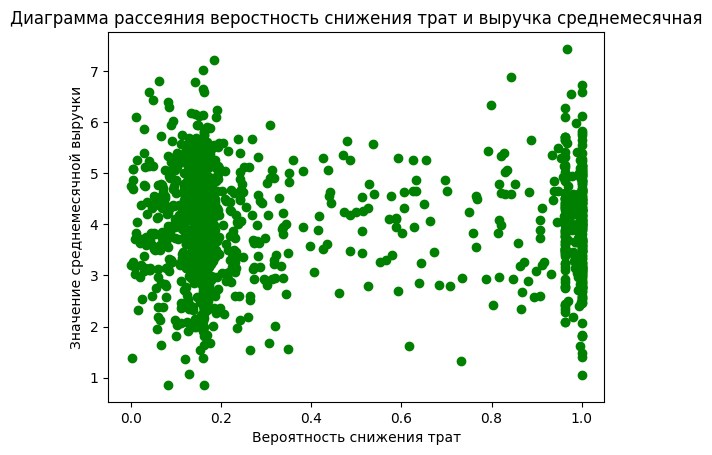

In [106]:
x = df_model['proba_class_снижается']
y = df_model['Прибыль']

plt.scatter(x, y, color='green', label='Данные')
plt.title('Диаграмма рассеяния веростность снижения трат и выручка среднемесячная')
plt.xlabel('Вероятность снижения трат')
plt.ylabel('Значение среднемесячной выручки')
plt.show()

In [107]:
df_model['Прибыль'].describe()

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

Предлагаю выделить следующий сегмент:
- вероятность снижения покупательской активности более 0,8 и значение среднемесячной выручки больше медианной 4,04

- а также чья доля акционных покупок менее 0,33

In [108]:
target_segm = df_model.query('proba_class_снижается > 0.8 & Прибыль > 4.04 & Акционные_покупки < 0.33')

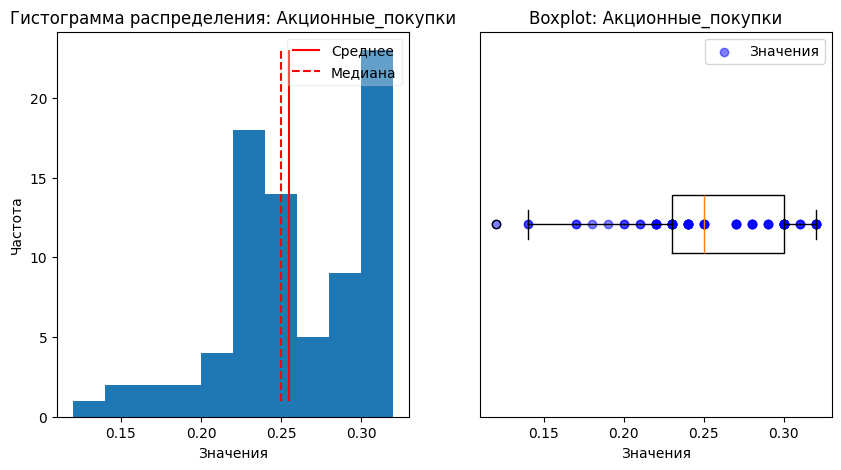

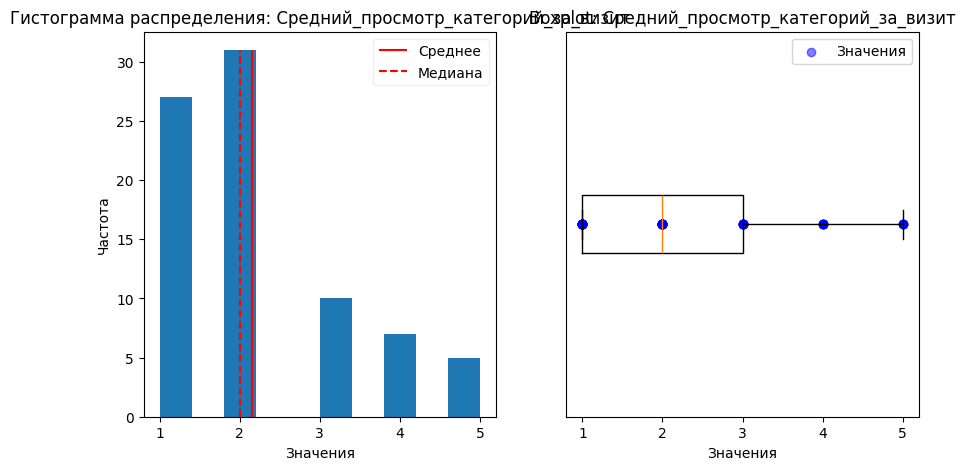

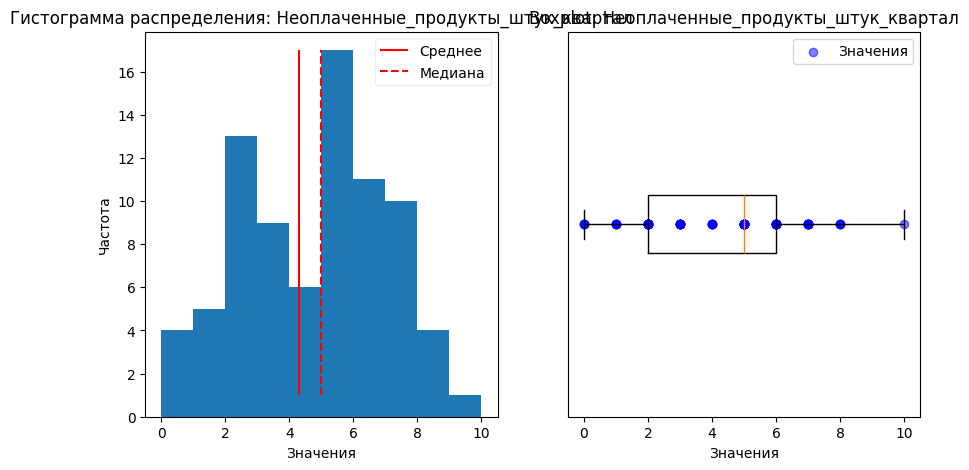

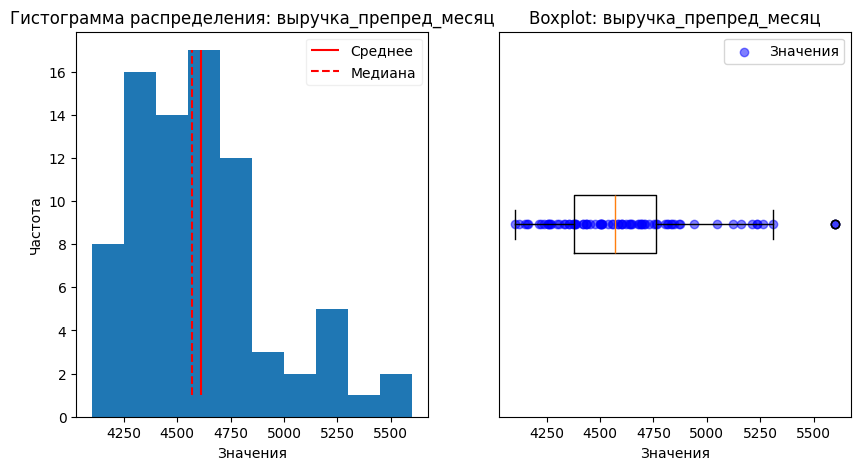

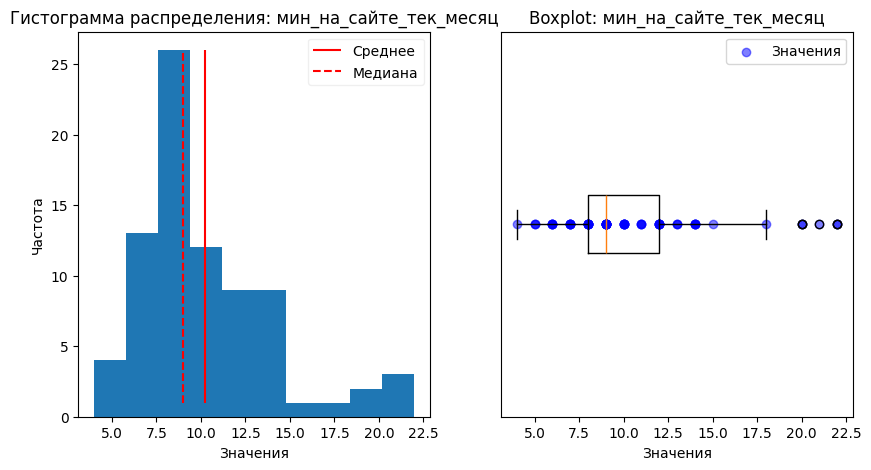

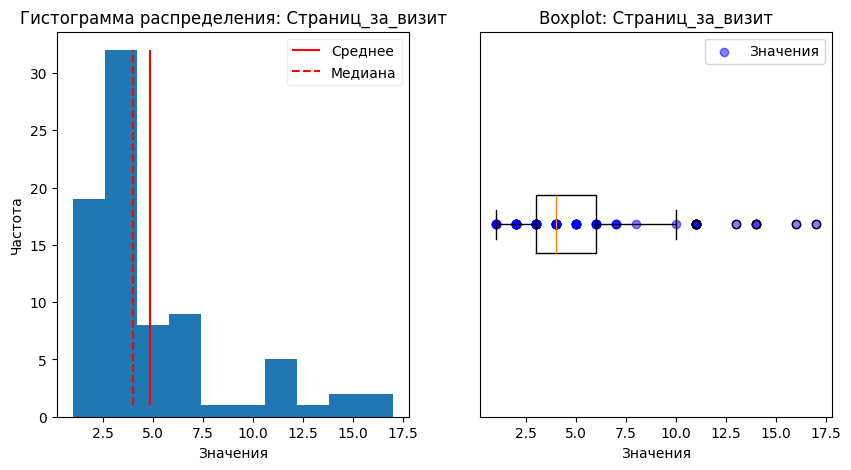

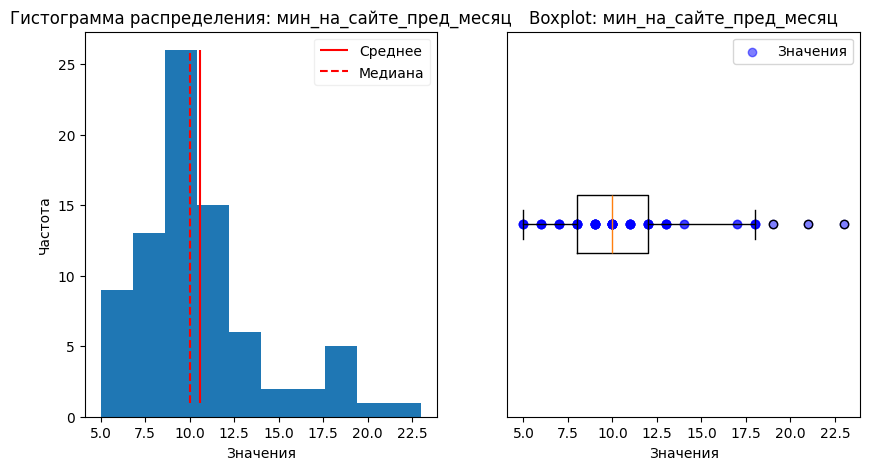

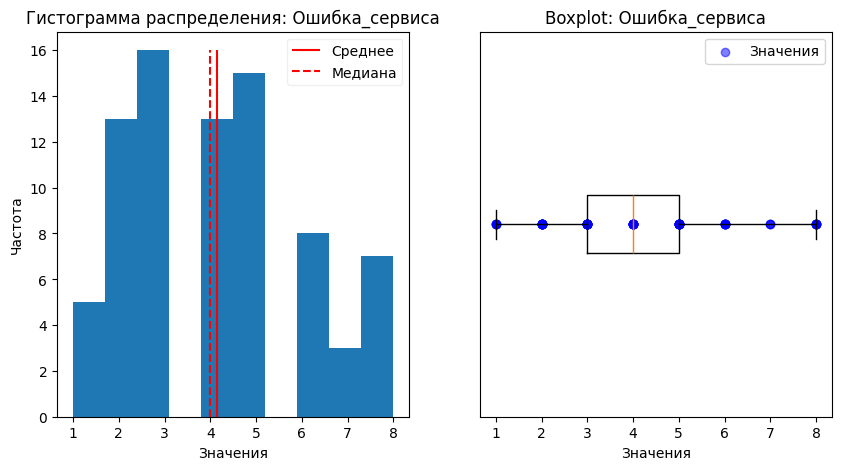

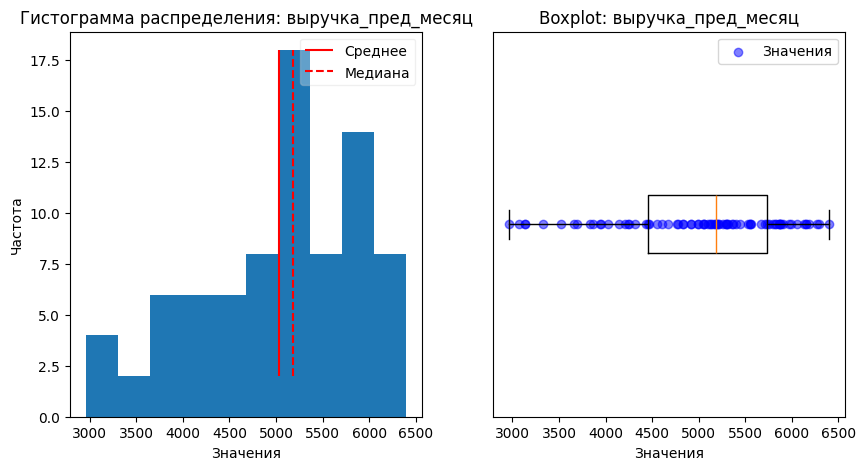

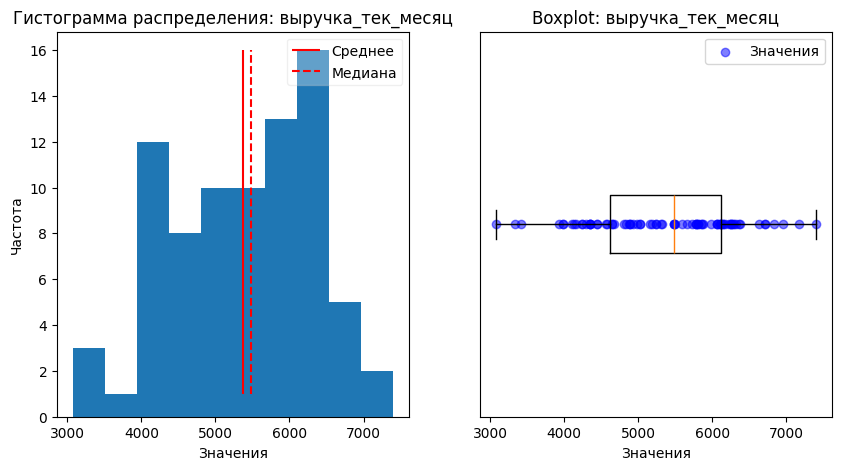

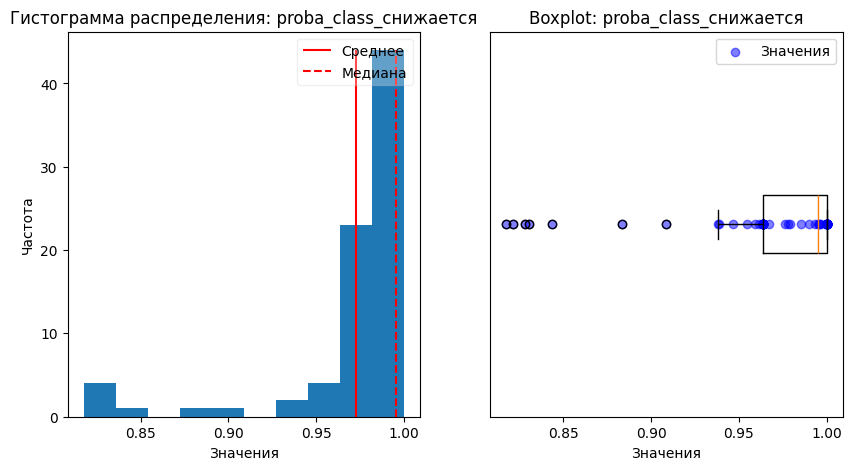

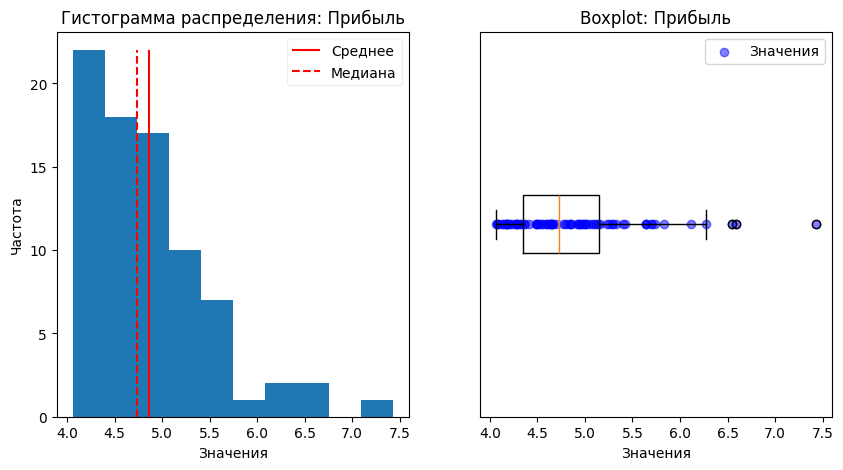

<Figure size 200x200 with 0 Axes>

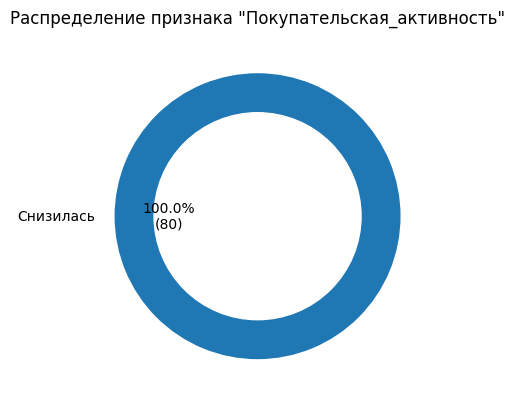

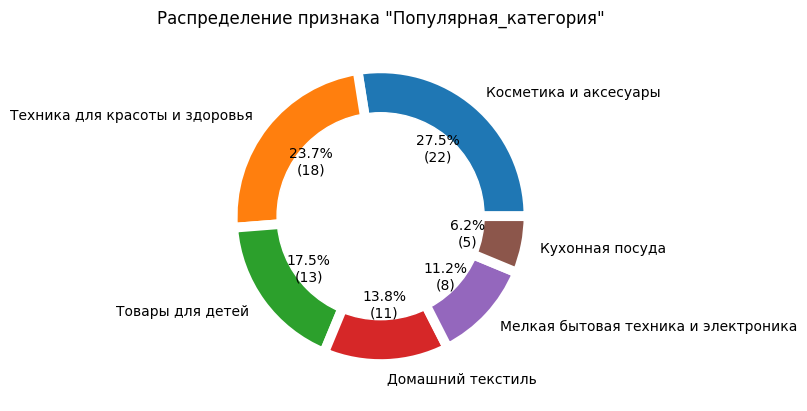

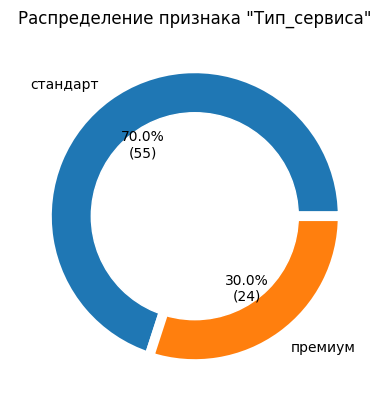

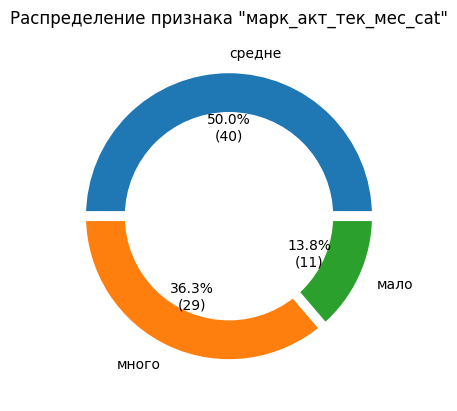

In [109]:
exploratory_analysis(target_segm)

In [110]:
target_segm.describe()

,Маркет_актив_6_мес,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,выручка_препред_месяц,мин_на_сайте_тек_месяц,Страниц_за_визит,мин_на_сайте_пред_месяц,Ошибка_сервиса,выручка_пред_месяц,выручка_тек_месяц,proba_class_снижается,Прибыль
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,3.517500,0.255000,2.150000,4.312500,4610.000000,10.250000,4.87500,10.562500,4.137500,5031.650000,5371.161250,0.972460,4.865250
std,0.987104,0.046877,1.170308,2.286968,330.395582,3.872983,3.56628,3.713962,1.940532,860.081765,946.411998,0.043981,0.656471
min,0.900000,0.120000,1.000000,0.000000,4102.000000,4.000000,1.00000,5.000000,1.000000,2960.000000,3078.300000,0.817402,4.060000
25%,2.900000,0.230000,1.000000,2.000000,4377.250000,8.000000,3.00000,8.000000,3.000000,4458.875000,4626.750000,0.963843,4.352500
50%,3.500000,0.250000,2.000000,5.000000,4571.000000,9.000000,4.00000,10.000000,4.000000,5183.000000,5487.300000,0.995343,4.730000
75%,4.125000,0.300000,3.000000,6.000000,4764.500000,12.000000,6.00000,12.000000,5.000000,5736.000000,6125.075000,1.000000,5.145000
max,5.800000,0.320000,5.000000,10.000000,5601.000000,22.000000,17.00000,23.000000,8.000000,6399.500000,7401.600000,1.000000,7.430000


Итак, выделив сегмент ниже и определив выше факторы, которые больше всего влияют на снижение покупательской активности, можно сделать следующие выводы и предложения:
~~- самый важный признак, это маркетинговый контакт с пользователем в текщем месяце. Мы наблюдаем, что по выделенному сегменту, только у 51,7% (89 пользователей) был контакт 5 раз, у 30% мало, 3 раза, и у 17% 4 раза были задействованы коммуникации. ~~


- необходимо проработать методы удержания клиента на сайте и увелечения количества стараниц, посещенных на сайте
- необходимо уделить внимание увеличению маркетинговых активностей

### Общий вывод

- В ходе анализа данных покупателей интернет магазина  «В один клик» проделано следующее:

- Выполнен исследовательский анализ данных покупателей.
    - Покупательская активность. 62% - снизилась, 38 - прежний уровень
    - Тип сервиса. 71% премиум, 29% стандарт
    - Разрешить сообщать. 74% да, 26% - нет
    - Популярная_категория. Товары для детей наиболее популярная категория, 25%,  далее по убыванию - домашний текстиль,косметика и аксесуары, техника для красоты и здоровья, кухонная посуда, мелк быт техника.
    - Время проведенное на сайте распределено нормально, медиана почти равна среднему 13 минут, выбросов нет
    - среднемесячная прибыль распределение похоже на нормальное, медиана почти равна среднему, 4.

- Выполнен подбор лучшей модели МО, способной предсказывать целевой признак Покупательская активность, снизится она или удержиться на текущем уровне
    - Был применен передовой инструмент по определению корреляций признаков
    - Обучены и перепробованы 4 разных типа моделей МО с разными параметрами и методами кодирования и масштабирования данных
    - Выбрана лучшая модель и параметры по предсканию целевого признака, модель показала точность присваивания корректного класса в 93%, результат очень хороший
    - Тем самым определены признаки наиболее влияющие на целевой
    - Предложены пути решения поставленной задачи уменьшения доли покупателей со снижением покупательской активности
    - Увеличение маркетинговых контактов до 5 в месяц, сокращение ошибок сервиса в приоритете.